# Heat transfer for pipes

In [1]:
%matplotlib inline 
# plots graphs within the notebook
%config InlineBackend.figure_format='svg' # not sure what this does, may be default images to svg format

from IPython.display import Image

from IPython.core.display import HTML
def header(text):
    raw_html = '<h4>' + str(text) + '</h4>'
    return raw_html

def box(text):
    raw_html = '<div style="border:1px dotted black;padding:2em;">'+str(text)+'</div>'
    return HTML(raw_html)

def nobox(text):
    raw_html = '<p>'+str(text)+'</p>'
    return HTML(raw_html)

def addContent(raw_html):
    global htmlContent
    htmlContent += raw_html
    

### Library of thermal resistances

In [11]:
%%file HT_thermal_resistance.py
### definition of thermal resistance ###

import numpy as np
import math
import scipy.constants as sc

def R_th_cond_plane(k,L,A):
    return L/(k*A)

def R_th_cond_cylindrical(k,r_a,r_b,L):
    return np.log(r_b/r_a)/(2.*math.pi*L*k)


def R_th_cond_spherical(k,r_a,r_b,L):
    return (1./r_a-1./r_b)/(4.*math.pi*k)

def R_th_convection(h,A):
    return 1./(h*A)

def R_th_radiation(eps,T_s,T_infty,A):
    return 1./(eps*sc.sigma*(T_s+T_infty)*(T_s**2+T_infty**2)*A)

### summation of thermal resistance (R is a vector) ###
def serial_sum(R):
    return np.sum(R)

def parallel_sum(R):
    return 1./(np.sum(1./R))

Writing HT_thermal_resistance.py


### Library of Nu correlations for external flow around a pipe

In [12]:
%%file HT_external_convection_cylinder.py
def Nu_Hilbert(Re,Pr):
    if (Re < 0.4) or (Re > 400000.):
        Nu = 0.
    else:
        if (Re < 4.):
            C = 0.989
            m = 0.33
        elif (Re < 40.):
            C = 0.911
            m = 0.385
        elif (Re < 4000.):
            C = 0.683
            m = 0.466
        elif (Re < 40000.):
            C = 0.193
            m = 0.618
        else:
            C = 0.027
            m = 0.805
        Nu = C*Re**m*Pr**(1./3.)
    return Nu

def Nu_Churchill_Bernstein(Re,Pr):
    
    if (Re*Pr < 0.2):
        Nu = 0.
    
    else:
        Nu = 0.3+(0.62*Re**(0.5)*Pr**(1./3.)) \
          /(1.+(0.4/Pr)**(2./3.))**(1./4.) \
        *(1.+(Re/282000.)**(5./8.))**(4./5.)
    return Nu

def Nu_Zukauskas(Re,Pr,Pr_s):
    if (Pr <= 10):
        n = 0.37
    else:
        n = 0.36
    inbound = True
    if (Re < 1.) and (Re > 1.e6):
        Nu = 0.
    else:
        if (Re < 40.):
            C = 0.75
            m = 0.4
        elif (Re < 1000.):
            C = 0.51
            m = 0.5
        elif (Re < 2.e5):
            C = 0.26
            m = 0.6
        else:
            C = 0.076
            m = 0.7
        Nu = C*Re**m*Pr**n*(Pr/Pr_s)**(1./4.)
    return Nu

Writing HT_external_convection_cylinder.py


### Library of Nu correlations and functions for internal flow in pipes

In [13]:
%%file HT_internal_convection.py
import numpy as np
import scipy
import scipy.optimize

def linear_interpolation(x_t,x_1,x_2,y_1,y_2):
    return y_1+(y_2-y_1)*(x_t-x_1)/(x_2-x_1)

def pressure_drop_pipe(f,L,D,rho,u_m):
    return f*(L/D)*(rho*u_m**2)/2.

def f_pipe_laminar(Re_D):
    return 64./Re_D

def f_pipe_colebrook(Re_D,eps):
    Re = Re_D
    e = eps
     
    f_0 = (0.790*np.log(Re)- 1.64)**(-2.)
    if (e > 0.):
        f_1 = 1./(-2.0*np.log10(e/3.71))**2
    else:
        f_1 = f_0
    f_guess = np.max(f_0,f_1)
    #f_guess = 0.04
    def f_tmp(x):
        y = (-2*np.log10((2.51/(Re*np.sqrt(x))) + (e/(3.71))) - 1.0/np.sqrt(x))
        return y
    y = scipy.optimize.fsolve(f_tmp, f_guess)
    return y
def log_mean_temperature(T_s,T_o,T_i):
    if (T_s < min(T_o,T_i)):
        DT_o = T_o-T_s
        DT_i = T_i-T_s
    elif (T_s > max(T_o,T_i)):
        DT_o = T_s-T_o
        DT_i = T_s-T_i
    return (DT_o-DT_i)/np.log(DT_o/DT_i)

def T_mx_Ts_constant(T_s,T_mi,P,mdot,Cp,hbar,x):
    return T_s-(T_s-T_mi)*np.exp(-P*x*hbar/(mdot*Cp))

def T_mo_T_infty(T_infty,T_mi,P,L,mdot,Cp,R_tot):
    return T_infty-(Tinfty-T_mi)*np.exp(-1/(mdot*Cp*Rtot))

def hbar_laminar_isothermal(k,D):
    return 3.66*k/D

def hbar_laminar_isoflux(k,D):
    return 4.36*k/D

def Nu_turbulent_Dittus_Boelter(Re,Pr,mode):
    if (mode == 'heating'):
        n = 0.4
    elif (mode == 'cooling'):
        n = 0.3
    return 0.023*Re**(4./5.)*Pr**n

def Nu_turbulent_Sieder_Tate(Re,Pr,mu,mu_s):
    return 0.027*Re**(4./5.)*Pr*(1./3.)*(mu/mu_s)**0.14

def Nu_turbulent_Gnielinski(Re,Pr,f):
    return (f/8.)*(Re-1000.)*Pr/(1+12.7*(f/8.)**0.5*(Pr**(2./3.)-1.))

def Nu_turbulent_Skupinski(Re,Pr):
    return 4.82+0.0185*(Re*Pr)**0.827

def Nu_turbulent_Seban(Re,Pr):
    return 5.0+0.025*(Re*Pr)**0.8

Writing HT_internal_convection.py


### Library for natural convection around cylinders

In [14]:
%%file HT_natural_convection_cylinder.py
import numpy as np
import scipy
import scipy.optimize

def Gr(g,beta,DT,D,nu):
    return (g*beta*DT*D**3)/(nu**2)

def Ra(g,beta,DT,D,nu,alpha):
    return (g*beta*DT*D**3)/(nu*alpha)


def Nu_Morgan(Ra):
    if (Ra <= 1e-2):
        C=0.675
        n=0.058
    elif (Ra <= 1e2):
        C=1.02
        n=0.148
    elif (Ra <= 1e4):
        C=0.85
        n=0.188
    elif (Ra <= 1e7):
        C=0.480
        n=0.250
    elif (Ra <= 1e12):
        C=0.125
        n=0.333
    return C*Ra**n

def Nu_Churchill_Chu(Ra,Pr):
    return (0.60+(0.387*Ra**(1./6.))/(1.+(0.559/Pr)**(9./16.))**(8./27.))**2 


Writing HT_natural_convection_cylinder.py


### Library for thermodynamic properties

Defines thermodynamic properties of air and water at 1 atm. Air properties are tabled between $-150\text{$^\circ$C}$ and $400\text{$^\circ$C}$, water between $274\text{K}$ and $373\text{K}$
<p class='alert alert-danger'>
<b>Input must be in Kelvin</b>
</p>
Use the scipy functions <FONT FACE="courier" style="color:blue">C2K </FONT> and <FONT FACE="courier" style="color:blue">F2K </FONT> to convert temperatures to Kelvin. Thermodynamic properties are linearly interpolated from the two nearest temperature states.

In [15]:
%%file thermodynamics.py
import numpy as np
import scipy
import scipy.optimize
from scipy.constants.constants import C2K
from scipy.constants.constants import K2C
from scipy.constants.constants import F2K
from scipy.constants.constants import K2F
import scipy.constants as sc

def interpolate_table(target,index,xquantity,yquantity):
    return yquantity[index] + \
                (yquantity[index+1]-yquantity[index])* \
                (target-xquantity[index])/(xquantity[index+1]-xquantity[index])

def water_look_up_1atm(T_o):
    T,p,rho,Cp,mu,k = \
    np.genfromtxt('tables/water1atm.csv', delimiter=',', skip_header = 1, unpack=True, dtype=None)
    Ntab = len(T)
    Cp *= 1e3
    nu = mu/rho 
    alpha = k/(rho*Cp)
    Pr = nu/alpha
    dT = T[1] - T[0]
    i = int((T_o-T[0])/dT)
    if (i == Ntab - 1):
        i == Ntab - 2
    rho_o = interpolate_table(T_o,i,T,rho)
    Cp_o = interpolate_table(T_o,i,T,Cp)
    mu_o = interpolate_table(T_o,i,T,mu)
    k_o = interpolate_table(T_o,i,T,k)
    nu_o = interpolate_table(T_o,i,T,nu)
    alpha_o = interpolate_table(T_o,i,T,alpha)
    Pr_o = interpolate_table(T_o,i,T,Pr)
    # compute beta from -rho(d rho/dT)
    beta = -(1./rho)*np.gradient(rho)/dT
    beta_o = interpolate_table(T_o,i,T,beta)
    return rho_o,Cp_o,mu_o,k_o,nu_o,alpha_o,Pr_o,beta_o

def air_look_up_1atm(T_o):
    T,rho,Cp,k,nu,beta,Pr = \
    np.genfromtxt('tables/air1atm.csv', delimiter=',', skip_header = 1, unpack=True, dtype=None)
    Ntab = len(T)
    T = C2K(T)
    Cp *= 1e3
    nu *= 1e-6
    mu = rho*nu
    alpha = k/(rho*Cp)
    Pr = nu/alpha
    i = 0
    while (T[i] < T_o) and (i<Ntab):
        i += 1
    i -=1
    if (i == Ntab - 1):
        i == Ntab - 2
    rho_o = interpolate_table(T_o,i,T,rho)
    Cp_o = interpolate_table(T_o,i,T,Cp)
    k_o = interpolate_table(T_o,i,T,k)
    nu_o = interpolate_table(T_o,i,T,nu)
    mu_o = interpolate_table(T_o,i,T,mu)
    alpha_o = interpolate_table(T_o,i,T,alpha)
    Pr_o = interpolate_table(T_o,i,T,Pr)
    beta = 1./T_o
    return rho_o,Cp_o,mu_o,k_o,nu_o,alpha_o,Pr_o,beta

Writing thermodynamics.py


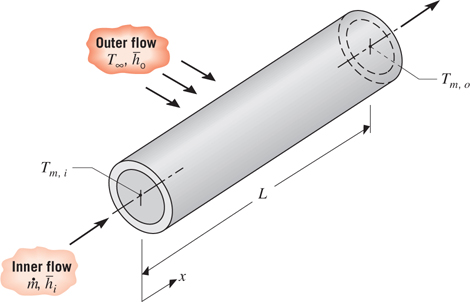

In [16]:
Image(filename='figures/fig_08_08.jpg')

#### Fig. 1: Illustration of internal convection

The above sketch illustrates the focus of this notebook: How to quantify the heat transfer between a pipe, in which a fluid flows, and its surroundings. The heat transfer from the outer surface of the pipe to the outer flow is to defined in the previous chapter, external convection. In the following, this notebook establishes the tools necessary to solve the internal convection problem.

## Entry flow and fully developed internal flow

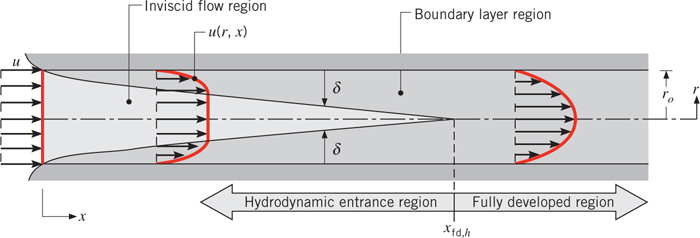

In [17]:
Image(filename='figures/fig_08_01.jpg')

#### Fig. 2: Pipe flow

A uniform flow entering a pipe (Fig. 2) first experiences streamwise variation of velocity to accommodate the wall boundary conditions. A boundary layer, of thickness $\delta$, forms on the wall and grows until its edge reaches the pipe centerline. This region is the hydrodynamic entrance region. Beyond that point, the flow becomes fully developed, which means that
<ul>
<li> In the laminar regime, the velocity profile is only a function of $r$,</li>
<li> In the turbulent regime, the <b>mean</b> velocity profile is only a function of $r$.</li>
</ul>
An important quantity is the friction drag exerted by the flow onto the pipe wall, since it governs the pressure gradient. In fully developed (laminar or turbulent) regimes, the pressure gradient may be determined by
<FONT FACE="courier" style="color:blue">pressure_drop_pipe(f,L,D,rho,u_m)</FONT>
<p class='alert alert-danger'>
$$
-\frac{\Delta\overline{P}}{L}=f\,\frac{1}{D}\,\frac{\rho U_m^2}{2}
$$
</p>
where $D=2R$ and $L$ are the diameter and length of the pipe, respectively, and $f$ is the <b>friction factor</b>. The bulk velocity or average velocity is
<p class='alert alert-info'>
$$
U_m=\frac{\dot{m}}{\rho A_c}
$$
</p>
where $\dot{m}$ is the mass flux
$$
\dot{m}=\int_0^{2\pi}\int_0^R\rho \overline{u}(r)\,r\,dr d\theta=2\pi\int_0^R\rho \overline{u}(r)\,r\,dr
$$
and $A_c=\pi R^2$
The Reynolds number of the flow is based on the bulk velocity and pipe diameter:
<p class='alert alert-danger'>
$$
Re_D=\frac{\rho U_mD}{\mu}=\frac{4\dot{m}}{\pi D\mu}
$$
</p>
The friction factor in the laminar regime is rigorously derived:
<FONT FACE="courier" style="color:blue">f_laminar(Re_D)</FONT>
<p class='alert alert-danger'>
$$
f = \frac{64}{Re_D}
$$
</p>
and is valid up to the critical Reynolds number $Re_{D,c}$, which in most pipe is around 2,000.
Beyond the critical Reynolds number, $f$ is a function of the roughness to diameter ratio $\varepsilon=e/D$ (e is typically the standard deviation of the roughness height) and the Reynolds number. An trustworthy empirical correlation is the Colebrook formula:
<FONT FACE="courier" style="color:blue">f_pipe_colebrook(Re_D,eps)</FONT>
<p class='alert alert-danger'>
$$
\frac{1}{\sqrt{f}}=-2\log_{10}\left[\frac{\varepsilon}{3.7}+\frac{2.51}{Re_D\sqrt{f}}\right]
$$
</p>
which is solved below for a range of relative roughness $\varepsilon$.
Often there is a need to determine the pump or blower power $P$ necessary to move the flow at a prescribed pressure drop:
<p class='alert alert-danger'>
$$
P=\frac{\dot{m}}{\rho}\Delta p= \underbrace{(\Delta p)A_c}_\text{force}\cdot U_m
$$
</p>

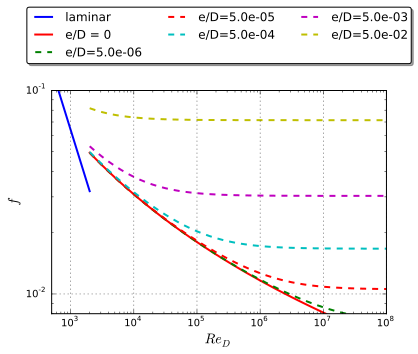

In [18]:
%matplotlib inline 
# plots graphs within the notebook
%config InlineBackend.figure_format='svg' # not sure what this does, may be default images to svg format

import matplotlib.pyplot as plt #calls the plotting library hereafter referred as to plt

import numpy as np
import scipy
import scipy.optimize

import HT_internal_convection as internal

font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 14,
        }
eps = 0.0


Re_min = 2.e3
Re_max = 2.e8
n = 51
Re_D = 2.*np.logspace(3.0,8.0,n)
f = np.zeros(n)
f_0 = 0.04
Re_lam = 2.*np.logspace(2.0,3.0,n)
f_lam = np.array([64./Re_lam[i] for i in range(n)])
for i in range(n):
    f[i] = internal.f_pipe_colebrook(Re_D[i],0.)
    
plt.figure(figsize=(6,4), dpi=200)
plt.loglog(Re_lam,f_lam, lw=2, label='laminar')
plt.loglog(Re_D,f,'r', lw = 2, label='e/D = 0')
neps = 5
eps_m = 5.*np.logspace(-6.0,-2.0,neps)
#eps_m = np.array([0.])
for eps in eps_m:
    for i in range(n):
        f[i] = internal.f_pipe_colebrook(Re_D[i],eps)
    s ="e/D=%.1e" %eps
    plt.loglog(Re_D,f,'--',lw = 2, label = s)
    
plt.grid(True)
plt.ylim(.008,0.1)
plt.xlim(5e2,1.e8)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4),ncol=3, fancybox=True, shadow=True)
plt.xlabel('$Re_D$', fontdict=font)
plt.ylabel('$f$', fontdict=font)

plt.show()

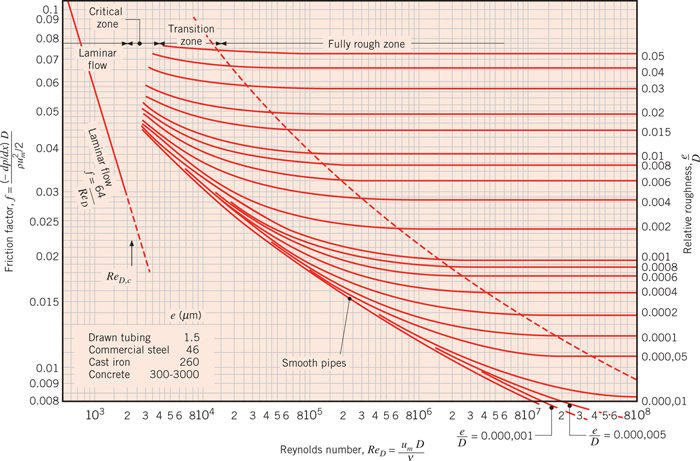

In [19]:
Image(filename='figures/fig_08_03.jpg')

#### Fig. 3: Friction factor in pipe flows as a function of Reynolds number and relative roughness

## Heat transfer by internal convection

The temperature is expected to vary both in the streamwise direction and in the radial direction. To reduce the complexity of the problem, we define the mean temperature as:
$$
T_m=\frac{1}{\dot{m}C_p}\int_{A_c}\rho\,u\,C_p\, T\,dA_c
$$
where $\dot{m}$ is the mass flow rate, $rho$ and $C_p$ are the density and specific heat of the fluid and $A_c$ is the cross-sectional area of the pipe.
The local heat flux may be now expressed as:
$$
q_s''=h(T_s-T_m)
$$
where $h$ is the <b>local</b> convection heat transfer coefficient and $T_s$ is the surface temperature on the inner wall of the pipe. The variation of temperature in the <b>fully developed</b> flow can be shown to be governed by the following ODE:
<p class='alert alert-info'>
$$
\frac{dT_m}{dx}=\frac{P}{\dot{m}C_p}h(T_s-T_m)
$$
</p>
where $P$ is the perimeter of the pipe.
If the local heat flux is maintained constant over the length of the pipe $L$, the total heat rate is 
<p class='alert alert-danger'>
$$
q_\text{conv}=(PL)q_s''\, \text{$q_s''=$constant}
$$
</p>
and the streamwise distribution of the mean temperature is linear:
$$
T_m(x)=T_{m,i}+\frac{q_s''P}{\dot{m}C_p}x,\, \text{$q_s''=$constant}
$$
For the case of constant wall temperature $T_s$, the temperature distribution is the solution of the above ODE, thus of exponential nature. For practical applications, you most always need to compute the overall heat transfer and the outlet mean temperature $T_{m,o}$. The integration of the above ODE for $x=0$ to $x=L$ yields
<p class='alert alert-danger'>
$$
\frac{T_s-T_{m,o}}{T_s-T_{m,i}}=\exp\left(-\frac{PL}{\dot{m}C_p}\overline{h}\right),\, \text{$T_s=$constant}
$$
</p>
where 
$$
\overline{h}=\frac{1}{L}\int_0^L h(x)dx
$$
If you must compute the mean temperature at $x$ an integration from $0$ to $x$ yields
<FONT FACE="courier" style="color:blue">T_mx_Ts_constant(T_s,T_mi,P,L,mdot,Cp,hbar,x)</FONT>
<p class='alert alert-danger'>
$$
\frac{T_s-T_{m}(x)}{T_s-T_{m,i}}=\exp\left(-\frac{PL}{\dot{m}C_p}\overline{h}_x\right),\, \text{$T_s=$constant}
$$
</p>
where 
$$
\overline{h}_x=\frac{1}{L}\int_0^x h(x')dx'
$$
The computation of the total heat transfer rate can be shown to write:
<p class='alert alert-danger'>
$$
q_\text{conv}=\overline{h}(PL)\Delta T_\text{lm},\, \text{$T_s=$constant}
$$
</p>
with the log mean temperature
<FONT FACE="courier" style="color:blue">log_mean_temperature(T_s,T_o,T_i)</FONT>
<p class='alert alert-danger'>
$$
\Delta T_\text{lm}=\cfrac{T_{m,i}-T_{m,o}}{\ln\left(\cfrac{T_s-T_{m,o}}{T_s-T_{m,i}}\right)}
$$
</p>
In many problem, $T_s$ is not defined but the outside ambient temperature $T_\infty$, the thermal conductivity of the pipe is known. One needs to determine the total resistance of the system $R_\text{tot}$, which requires calculating the heat transfer coefficient of the forced or natural convection, occuring on the outside of the pipe, the radiation coefficient if needed, the thermal resistance due by conduction within the pipe, which may include multiple components in the presence of insulation for example, and the internal convection heat transfer coefficient (to be defined below). In such cases, the variation of temperature between inlet and outlet becomes:
<FONT FACE="courier" style="color:blue">T_mo_T_infty(T_infty,T_mi,P,L,mdot,Cp,R_tot)</FONT>
<p class='alert alert-danger'>
$$
\frac{T_\infty-T_{m,o}}{T_\infty-T_{m,i}}=\exp\left(-\frac{1}{\dot{m}C_pR_\text{tot}}\right)
$$
</p>
and the total heat transfer rate is
<p class='alert alert-danger'>
$$
q=\frac{\Delta T_\text{lm}}{R_\text{tot}}
$$
</p>
The equations derived in this cell enable:
<ul>
<li> The computation of the internal convection heat transfer coefficient if $T_{m,i}$ and $T_{m,o}$ are known.</li>
<li> The computation of $T_{m,i}$ or $T_{m,o}$ if one is known and $\overline{h}$ is known </li>
<li> The computation of the required mass flux to achieve given $T_{m,i}$ and $T_{m,o}$, albeit through an iterative process</li>
</ul>

## Correlations for convection heat transfer coefficients in internal pipe flows

Here we detailed only the correlations for fully developed flows. For laminar flows, the nusselt numbers are constant, thus the library <FONT FACE="courier" style="color:blue">HT_internal_convection</FONT> provides directly $\overline{h}$:
<FONT FACE="courier" style="color:blue">hbar_laminar_isoflux(k,D) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=4.36,\, \text{$q_s''=$constant}
$$
</p>
<FONT FACE="courier" style="color:blue">hbar_laminar_isothermal(k,D) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=4.36,\, \text{$q_s''=$constant}
$$
</p>
In turbulent flows, there is a choice of correlations:
<FONT FACE="courier" style="color:blue">Nu_turbulent_Dittus_Boelter(Re,Pr,mode) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=0.023Re^{4/5}Pr^n
$$
<FONT FACE="courier" style="color:blue">Nu_turbulent_Sieder_Tate(Re,Pr,mu,mu_s) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=0.027Re^{4/5}Pr^{1/3}\left(\cfrac{\mu}{\mu_s}\right)^{0.14}
$$
<FONT FACE="courier" style="color:blue">Nu_turbulent_Gnielinski(Re,Pr,f) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=\frac{(f/8)(Re-1000)Pr}{1+12.7(f/8)^{1/2}(Pr^{2/3}-1)}
$$
<FONT FACE="courier" style="color:blue">Nu_turbulent_Skupinski(Re,Pr) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=4.82+0.0185\left(Re\,Pr\right)^{0.827},\, \text{$q_s''=$constant}
$$
<FONT FACE="courier" style="color:blue">Nu_turbulent_Seban(Re,Pr) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=5.0+0.025\left(Re\,Pr\right)^{0.8},\, \text{$T_s=$constant}
$$




## Natural convection around cylinder

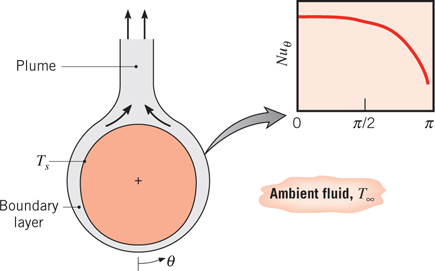

In [20]:
Image(filename='figures/fig_09_08.jpg')

#### Fig. 4: Illustration of the flow induced by natural convection around a cylinder. Insert shows the angular distribution of the local Nu.

In a fluid entirely at rest, a heated surface transfers its heat via pure conduction. Natural convection is the enhanced heat transfer between a body of fluid at rest (at infinity) and a heated surface through the creation of a convective flow driven by buoyancy forces. Fig. 4 illustrates a natural convection flow occuring around a cylinder. The fluid at the bottom of the cylinder $\theta=0$ becomes buoyant through heat transfer between the cylinder and the fluid and rises along the surface of the cylinder. This process creates two boundary layers that merge at $\theta = \pi$ to create a vertical jet-like flow, also called a plume. Plumes are characteristic flows of natural convection, i.e. they are found irrespective of the geometry of the heated object.

The non-dimensional numbers relevant to natural convection are:
the Grashof number
<FONT FACE="courier" style="color:blue">Grashof(g,beta,DT,D,nu) </FONT>
<p class='alert alert-danger'>
$$
Gr = \frac{g\beta(\Delta T)D^3}{\nu^2}
$$
</p>
and the Rayleigh number 
<FONT FACE="courier" style="color:blue">Rayleigh(g,beta,DT,D,nu,alpha) </FONT>
<p class='alert alert-danger'>
$$
Ra = Gr.Pr= \frac{g\beta(\Delta T)D^3}{\nu\alpha}
$$
</p>
where $g$ is the gravity magnitude, $\beta$ is the volumetric thermal expansion coefficient at a given pressure $p$
$$
\beta = -\frac{1}{\rho}\left(\frac{\partial\rho}{\partial T}\right)_p
$$
$\Delta T$ is the absolute temperature difference between the heated surface temperature $T_s$ and the fluid temperature at infinity $T_\infty$, $\Delta T= \vert T_s-T_\infty\vert$, $D$ is the characteristic length of the system (here the diameter) and $\nu$ and $\alpha$ are the kinematic viscosity and the thermal diffusivity, both of dimensions $\text{m$^2$/s}$. 
Note that for the ideal gas law
$$
p =\rho \frac{R}{M}T\text{ or } \rho = \frac{p}{\frac{R}{M}T}
$$
thus the expansion coefficient is 
<p class='alert alert-info'>
$$
\beta = \frac{1}{T}\text{ for an ideal gas, $T$ in K}
$$
</p>
For a liquid, $\beta$ must be interpolated from a table. All thermodynamics quantities involved are to be defined at the film temperature which is the arithmetic mean
<p class='alert alert-info'>
$$
T_f=\frac{T_s+T_\infty}{2} 
$$
</p>

The Grashof and Rayleigh number quantify the ratio of buoyancy to viscous forces. When they are large enough, a convective flow sets in and the heat transfer increases in comparison to pure conduction. The Nusselt number, ratio of convective to conduction heat transfer (i.e. $>1$ in the presence of a convection flow) is typically a power law of the Rayleigh number. In the case of the flow around a cylinder with isothermal surface temperature, there are two correlations:
<FONT FACE="courier" style="color:blue">Nu_Morgan(Ra) </FONT>
<p class='alert alert-danger'>
$$
\overline{Nu}=\frac{\overline{h}D}{k}=C\,Ra^n
$$
</p>
<FONT FACE="courier" style="color:blue">Nu_Churchill_Chu(Ra,Pr) </FONT>
<p class='alert alert-danger'>
$$
\overline{Nu}=\frac{\overline{h}D}{k}=\left[0.60+\frac{0.387Ra^{1/6}}{\left[1+\left(\frac{0.559}
{Pr}\right)^{9/16}\right]^{8/27}}
\right]^2 
$$
</p>
Both are valid for $Ra\leq10^{12}$. The Nusselt is averaged over the perimeter of the cylinder to account for the angular variation of heat transfer discussed earlier. The heat transfer from natural convection from a heated cylinder of diameter $D$ and length $L$ is
<p class='alert alert-info'>
$$
q=\overline{h}(\pi DL)(T_s-T_\infty)=\frac{1}{R_\text{th,conv}}(T_s-T_\infty)
$$
</p>
where $R_\text{th,conv}$ may computed with <FONT FACE="courier" style="color:blue">R_th_convection(h,A)</FONT>


## Assignment

<ol>
<li> Read this entire notebook. Using the textbook, add restrictions and range of validity for the above correlations when applicable. Add the entry length Nu correlation for laminar flow</li>
<li> Add a section on entrance flow</li>
<li> How should the entrance flow region be treated in turbulent flows?</li>
<li>Solve 8.31, 8.36, 8.43</li>
</ol>

### 8.31

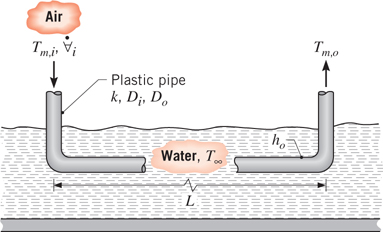

In [21]:
Image(filename='figures/probun_08_07.jpg')

To cool a summer home without using a vapor-compression refrigeration cycle, air is routed through a plastic pipe ($k=0.15\text{ W/m.K}$, $D_i=0.15\text{ m}$, $D_o=0.17\text{ m}$) that is submerged in an adjoining body of water. The water temperature is nominally at $T_\infty= 17^\circ\text{C}$, and a convection coefﬁcient of $h_o\approx 1500\text{ W/m$^2$. K}$ is maintained at the outer surface of the pipe.

If air from the home enters the pipe at a temperature of $T_{m,i}= 29^\circ\text{C}$ and a volumetric ﬂow rate of $\dot{\forall}_i= 0.025\text{ m$^3$/s}$, what pipe length $L$ is needed to provide a discharge temperature of $T_{m,o}=21^\circ\text{C}$? What is the fan power required
to move the air through this length of pipe if its inner surface is smooth?

In [27]:
%matplotlib inline 
# plots graphs within the notebook
%config InlineBackend.figure_format='svg' # not sure what this does, may be default images to svg format

import matplotlib.pyplot as plt #calls the plotting library hereafter referred as to plt

import numpy as np
import scipy
import scipy.optimize
from scipy.constants.constants import C2K
from scipy.constants.constants import K2C
from scipy.constants.constants import F2K
from scipy.constants.constants import K2F
import scipy.constants as sc

import HT_thermal_resistance as resistance
import HT_internal_convection as internal
import HT_natural_convection_cylinder as natural
import thermodynamics as thermo
### flow parameters
D_i = 0.15 #m
D_o = 0.17 #m
k_pipe = 0.15 #W/(m.K)
T_mi = 29. #C
T_mo = 21. #C
T_infty = 17 #C
Qdot = 0.025
U_m = Qdot/(np.pi*D_i**2/4.)
T_mean_air = (T_mi+T_mo)/2.
h_o = 1500 #W/m^2K

print('Air arithmetic mean temperature: %0.1f K' %(C2K(T_mean_air)))


Air arithmetic mean temperature: 298.1 K


In [28]:
rho_air,\
Cp_air,\
mu_air,\
k_air,\
nu_air,\
alpha_air,\
Pr_air,\
beta_air = thermo.air_look_up_1atm(C2K(T_mean_air))
Re_Di = rho_air*U_m*D_i/mu_air
mdot = rho_air*Qdot
print('rho_air= %0.3f' %(rho_air))
print('mu_air= %0.3e' %(mu_air))
print('k_air= %0.3e' %(k_air))
print('Pr_air= %0.3f' %(Pr_air))
print('Re_Di= %0.1f' %(Re_Di))

rho_air= 1.185
mu_air= 1.844e-05
k_air= 2.605e-02
Pr_air= 0.711
Re_Di= 13644.9


In [29]:
f = internal.f_pipe_colebrook(Re_Di,0.)
print('f= %0.4f' %(f))

f= 0.0285


In [30]:
hbar_i = internal.Nu_turbulent_Dittus_Boelter(Re_Di,Pr_air,'cooling')*k_air/D_i
A_i = np.pi*D_i
Rth = np.zeros(3)
Rth[0] = resistance.R_th_convection(hbar_i,A_i)
Rth[1] = resistance.R_th_cond_cylindrical(k_pipe,D_i,D_o,1.)
A_o = np.pi*D_o
Rth[2] = resistance.R_th_convection(h_o,A_o)
Rtot = resistance.serial_sum(Rth)
print('Thermal resistances (outer conv, cond, inner conv) per length:',Rth)
print(hbar_i)

('Thermal resistances (outer conv, cond, inner conv) per length:', array([ 0.28954649,  0.13280222,  0.00124827]))
7.32892992146


In [31]:

L = -np.log((T_infty-T_mo)/(T_infty-T_mi))*(mdot*Cp_air*Rtot)
s=('Required length L=%0.2f m' %L)
print(s)

Required length L=13.86 m


In [32]:
from scipy.constants import codata
p_i = codata.value('standard atmosphere')
print('Inlet temperature: %0.2f K' %C2K(T_mi))
M_air = 28.97e-3 #kg/mol
rho_i = p_i*28.97e-3/(sc.R*C2K(T_mi))
rho_i_table = internal.linear_interpolation(C2K(T_mi),300.,350.,1.1614,0.9950)
print('inlet density: %0.3f kg/m^3(ideal gas), %0.3f kg/m^3 (interpolation)' %(rho_i,rho_i_table))
Delta_P = internal.pressure_drop_pipe(f,L,D_i,rho_i,U_m)
Delta_P = f*(L/D_i)*(rho_i*U_m**2)/2.
Power = Delta_P*Qdot
print('Fan power: %0.3f W' %Power)


Inlet temperature: 302.15 K
inlet density: 1.168 kg/m^3(ideal gas), 1.154 kg/m^3 (interpolation)
Fan power: 0.077 W


### 8.36

Hot water at mean temperature $T_m=50\text{$^\circ$C}$ is routed from one building in which it is generated to an adjoining building in which it is used for space heating. Transfer between the buildings occurs in a steel pipe ($k=60\text{ W/m.K}$) of $100 \text{ mm}$ outside diameter and 8-mm wall thickness. During the winter, representative environmental conditions involve air at $T_\infty= -5\text{$^\circ$C}$ and $V_\infty=3\text{ m/s}$ in cross ﬂow over the pipe.
Using the Churchill Bernstein and Dittus Boehler correlations, calculate the total heat transfer rate <b>per unit length</b> $q'$, the daily energy cost $Q'=q'\times 24\text{ h/d}$ per meter and the cost per day and per meter assuming an electricity cost of $\text{\$}0.05\text{/kW.h}$.

In [19]:
%matplotlib inline 
# plots graphs within the notebook
%config InlineBackend.figure_format='svg' # not sure what this does, may be default images to svg format

import matplotlib.pyplot as plt #calls the plotting library hereafter referred as to plt

import numpy as np
import scipy
import scipy.optimize
from scipy.constants.constants import C2K
from scipy.constants.constants import K2C
from scipy.constants.constants import F2K
from scipy.constants.constants import K2F
import scipy.constants as sc

import HT_thermal_resistance as resistance
import HT_internal_convection as internal
import HT_natural_convection_cylinder as natural
import HT_external_convection_cylinder as external
import thermodynamics as thermo

print(C2K(50.),C2K((50-5.)/2.))

(323.14999999999998, 295.64999999999998)


In [20]:
D_o= 0.1
D_i = D_o-2.*8.0e-3
T_infty = C2K(-5.)
T_m = C2K(50.)
U_m = 0.5
#air
T_f=(T_infty+T_m)/2.
rho_air,\
Cp_air,\
mu_air,\
k_air,\
nu_air,\
alpha_air,\
Pr_air, \
beta_air = thermo.air_look_up_1atm(T_f)
print(rho_air,Cp_air,nu_air,k_air,alpha_air,Pr_air)
#water
rho_water,\
Cp_water,\
mu_water,\
k_water,\
nu_water,\
alpha_water,\
Pr_water,\
beta_water = thermo.water_look_up_1atm(T_m)

print(rho_water,Cp_water,mu_water,k_water,Pr_water,nu_water,alpha_water)
print(K2C(T_m),K2C(T_infty))

(1.1952500000000001, 1004.9999999999999, 1.5342499999999998e-05, 0.025875000000000002, 2.1559794279146413e-05, 0.71166329240491322)
(988.03250000000003, 4181.3450000000003, 0.00054686650000000019, 0.64359699999999997, 3.552917388218273, 5.5348987654142377e-07, 1.557854263683313e-07)
(50.0, -5.0)


In [21]:
#convection Resistance
Rth= np.zeros(3)
#external convection
V_infty = 3.
Re_air = rho_air*V_infty*D_o/mu_air
h_air = k_air/D_o*external.Nu_Churchill_Bernstein(Re_air,Pr_air)
print(K2C(T_m),K2C(T_infty))
#thermal resistance per unit length
Rth[0] = resistance.R_th_convection(h_air,np.pi*D_o)
#conduction within wall
k_pipe = 60.
Rth[1] = resistance.R_th_cond_cylindrical(k_pipe,D_i,D_o,1.)
#internal convection
Re_water = U_m*D_i/nu_water
h_water = k_water/D_i*internal.Nu_turbulent_Dittus_Boelter(Re_water,Pr_water,'cooling')

Rth[2] = resistance.R_th_convection(h_water,np.pi*D_i)
Rtot = resistance.serial_sum(Rth)
print(Rth)
qprime = 55./Rtot #(T_m-T_infty)/Rtot
print(T_m,T_infty)
print(K2C(T_m),K2C(T_infty))
print('qprime = %0.1f W/m' %qprime)
daily_loss = qprime*24.*1e-3
print('daily energy loss: %0.3f kW.h/d.m' %daily_loss)
cost = daily_loss * 0.05
print('cost: $%0.3f /m.d' %cost )

(50.0, -5.0)
[ 0.15692185  0.00046249  0.00183325]
(323.14999999999998, 268.14999999999998)
(50.0, -5.0)
qprime = 345.4 W/m
daily energy loss: 8.291 kW.h/d.m
cost: $0.415 /m.d


### 8.42

Atmospheric air enters a $10\text{ m}$-long, $150\text{ mm}$-diameter uninsulated heating duct at $60\text{$^\circ$C}$ and $0.04\text{ kg/s}$. The duct surface temperature is approximately constant at $Ts=15\text{$^\circ$C}$.

(a) What are the outlet air temperature, the heat rate q, and pressure drop $\Delta p$ for these conditions?

(b) To illustrate the tradeoff between heat transfer rate and pressure drop considerations, calculate $q$ and $\Delta p$ for diameters in the range from $0.1$ to $0.2\text{ m}$. In your analysis, maintain the total surface area,
$A_s=\pi DL$, at the value computed for part (a). Plot $q$, $\Delta p$, and $L$ as a function of the duct diameter.

In [22]:
%matplotlib inline 
# plots graphs within the notebook
%config InlineBackend.figure_format='svg' # not sure what this does, may be default images to svg format

import matplotlib.pyplot as plt #calls the plotting library hereafter referred as to plt

import numpy as np
import scipy
import scipy.optimize
from scipy.constants.constants import C2K
from scipy.constants.constants import K2C
from scipy.constants.constants import F2K
from scipy.constants.constants import K2F
import scipy.constants as sc

import HT_thermal_resistance as resistance
import HT_internal_convection as internal
import HT_natural_convection_cylinder as natural
import HT_external_convection_cylinder as external
import thermodynamics as thermo

In [23]:
D=0.15
T_mi = C2K(60.)
mdot = 0.04
T_s = C2K(15.)
T_m = (T_mi+T_s)/2.
rho_air,\
Cp_air,\
mu_air,\
k_air,\
nu_air,\
alpha_air,\
Pr_air, \
beta_air = thermo.air_look_up_1atm(T_m)
print(T_m,rho_air,Cp_air,nu_air,k_air,alpha_air,Pr_air)

(310.64999999999998, 1.1367499999999999, 1004.9999999999999, 1.67375e-05, 0.026924999999999998, 2.3588405745812832e-05, 0.70959921414956839)


In [24]:
Re = 4*mdot/(np.pi*D*mu_air) 
print(Re)

17860.1727027


In [25]:
hbar = k_air/D*internal.Nu_turbulent_Dittus_Boelter(Re,Pr_air,'cooling')
print(hbar)

9.38868460377


In [26]:
P = np.pi*D
L = 10.
T_mo = internal.T_mx_Ts_constant(T_s,T_mi,P,mdot,Cp_air,hbar,L)
print('T_mo= %0.2f C' %K2C(T_mo))

T_mo= 29.97 C


In [27]:
DT = T_mi-T_mo
q = mdot*Cp_air*DT
print('q= %0.1f W' %q)

q= 1207.2 W


In [28]:
f = internal.f_pipe_colebrook(Re,0)
print(f)

[ 0.02661587]


In [29]:
A =np.pi*D**2/4.
u_m = mdot/(rho_air*A)
print('Dp= %0.2f N/m^2' %internal.pressure_drop_pipe(f[0],L,D,rho_air,u_m))
print('Um= %0.3f m/s' %u_m)

Dp= 4.00 N/m^2
Um= 1.991 m/s


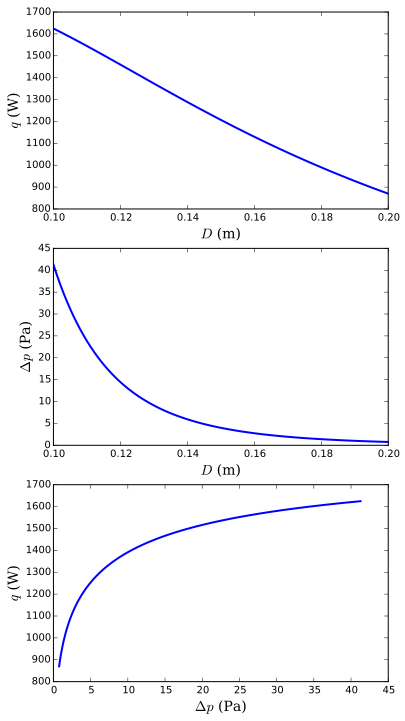

In [30]:
A_s = np.pi*D*L
N=100
Dvar = np.linspace(0.1,0.2,N)
Lvar = A_s/(np.pi*Dvar)
Revar = 4*mdot/(np.pi*Dvar*mu_air)
hbarvar = k_air/Dvar*internal.Nu_turbulent_Dittus_Boelter(Revar,Pr_air,'cooling')
Pvar = np.pi*Dvar
T_movar = internal.T_mx_Ts_constant(T_s,T_mi,Pvar,mdot,Cp_air,hbarvar,Lvar)
DTvar = T_mi-T_movar
qvar = mdot*Cp_air*DTvar
Avar =np.pi*Dvar**2/4.
u_mvar = mdot/(rho_air*Avar)
fvar = np.zeros(N)
for i in range(N):
    fvar[i] = internal.f_pipe_colebrook(Revar[i],0)
Dpvar = internal.pressure_drop_pipe(fvar,Lvar,Dvar,rho_air,u_mvar)
plt.figure(figsize=(6,12), dpi=200)
plt.subplot(3,1,1)
plt.plot(Dvar,qvar, lw = 2)
plt.xlabel('$D$ (m)', fontdict=font)
plt.ylabel('$q$ (W)', fontdict=font)
plt.subplot(3,1,2)
plt.plot(Dvar,Dpvar, lw = 2)
plt.xlabel('$D$ (m)', fontdict=font)
plt.ylabel('$\Delta p$ (Pa)', fontdict=font)
plt.subplot(3,1,3)
plt.plot(Dpvar,qvar, lw = 2)
plt.xlabel('$\Delta p$ (Pa)', fontdict=font)
plt.ylabel('$q$ (W)', fontdict=font)
plt.show()

In [32]:
!ipython nbconvert --to html Heat-transfer-pipes.ipynb

[NbConvertApp] Converting notebook Heat-transfer-pipes.ipynb to html
[NbConvertApp] Writing 1245623 bytes to Heat-transfer-pipes.html
